In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from utils import load_series_dfs

In [2]:
series_dfs = load_series_dfs(data_dir=r"C:\Users\johan\Documents\FH_Master\data", filename="final_learning_dfs.pkl")
series_dfs['FL_00024702.PLAN.MengeHH'].columns

Index(['consumption', 'hour', 'weekday', 'month', 'is_weekend', 'w_tl', 'w_rf',
       'w_ff', 'w_ffx', 'w_cglo', 'w_so_h', 'w_rr', 'w_rrm', 'w_tb10',
       'w_tb20', 'CEGH_WAP', 'THE_WAP'],
      dtype='object')

In [3]:
def prepare_consumption(df):
    s = df['consumption'].copy()
    s = s[~s.index.duplicated(keep='first')].sort_index()
    s = s.resample('h').interpolate().asfreq('h')
    z = (s - s.mean()) / (s.std() + 1e-9)
    return z

Z = {k: prepare_consumption(v) for k,v in series_dfs.items()}

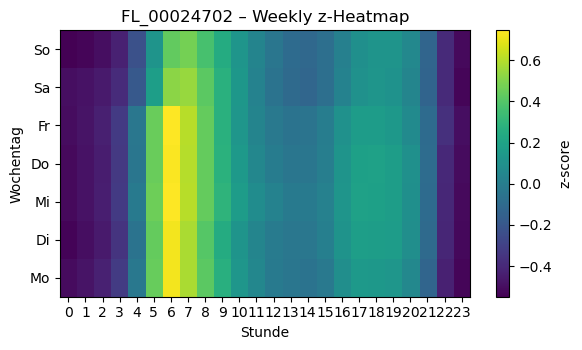

In [12]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def weekly_heatmap(z, title="Weekly profile heatmap"):
    g = z.groupby([z.index.weekday, z.index.hour]).mean().unstack()
    plt.figure(figsize=(6,3.6))
    plt.imshow(g.values, aspect='auto', origin='lower')
    plt.yticks(ticks=range(7), labels=['Mo','Di','Mi','Do','Fr','Sa','So'])
    plt.xticks(ticks=range(24), labels=range(24))
    plt.colorbar(label='z-score')
    plt.title(title); plt.xlabel('Stunde'); plt.ylabel('Wochentag'); plt.tight_layout()

# Beispiel:
weekly_heatmap(Z['FL_00024702.PLAN.MengeHH'], "FL_00024702 – Weekly z-Heatmap")

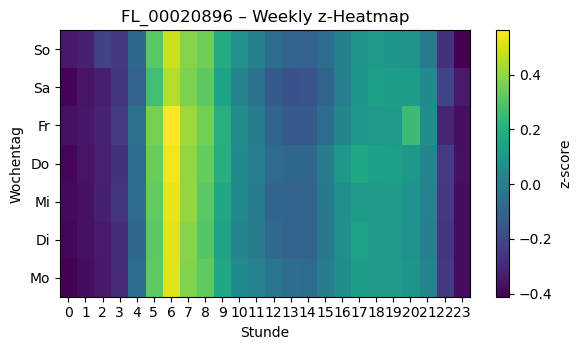

In [13]:
weekly_heatmap(Z['FL_00020896.PLAN.MengeHH'], "FL_00020896 – Weekly z-Heatmap")

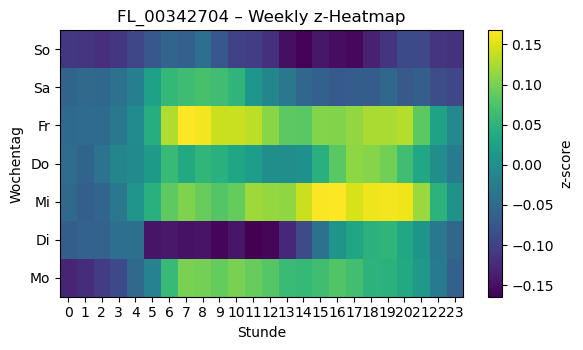

In [14]:
weekly_heatmap(Z['FL_00342704.PLAN.MengeGA'], "FL_00342704 – Weekly z-Heatmap")

In [6]:
from scipy.signal import correlate
from numpy.fft import rfft

def daily_profile(z):
    # Mittel pro Stunde (0..23)
    return z.groupby(z.index.hour).mean().to_numpy()  # (24,)

def weekly_profile(z):
    # Mittel je Wochentag-Stunde (7*24)
    g = z.groupby([z.index.weekday, z.index.hour]).mean().unstack().to_numpy().ravel()
    return g  # (168,)

def acf_features(z, lags=48*7):
    x = z.fillna(0).to_numpy()
    x = x - x.mean()
    c = correlate(x, x, mode='full')
    c = c[c.size//2: c.size//2 + lags + 1]
    c = c / (c[0] + 1e-9)
    # Nimm gezielt ACF bei 24h, 48h, 72h, 168h
    idx = [24, 48, 72, 168]
    feats = [c[i] if i < len(c) else 0.0 for i in idx]
    return np.array(feats, dtype=float)  # (4,)

def fourier_feats(z, k=10):
    x = z.fillna(0).to_numpy()
    mag = np.abs(rfft(x))
    # ignoriere DC, nimm Top-k Frequenzen (ohne DC)
    mag[0] = 0.0
    topk = np.sort(mag)[-k:]
    # energie-normieren
    topk = topk / (np.linalg.norm(topk) + 1e-9)
    return topk   # (k,)

def build_embedding(z):
    d = daily_profile(z)                    # 24
    w = weekly_profile(z)                   # 168
    a = acf_features(z)                     # 4
    f = fourier_feats(z, k=10)              # 10
    # z-Score je Block, damit keiner dominiert
    def znorm(v): return (v - v.mean()) / (v.std() + 1e-9)
    emb = np.concatenate([znorm(d), znorm(w), a, f])  # 24+168+4+10 = 206
    return emb

EMB = {k: build_embedding(z) for k,z in Z.items()}
keys = list(EMB.keys())
X = np.vstack([EMB[k] for k in keys])  # (n_series, 206)

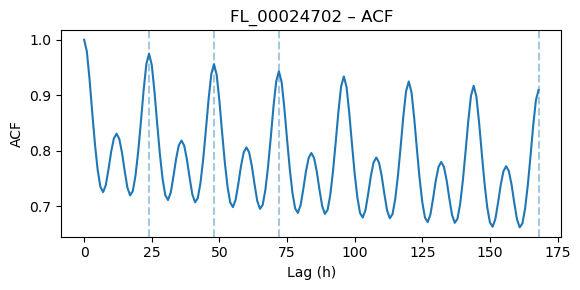

In [15]:
from scipy.signal import correlate

def acf_plot(z, max_lag=24*7, marks=[24,48,72,168], title="ACF"):
    x = z.fillna(0).to_numpy()
    x = x - x.mean()
    c = correlate(x, x, mode='full')
    c = c[c.size//2: c.size//2 + max_lag + 1]
    acf = c / (c[0] + 1e-9)
    plt.figure(figsize=(6,3))
    plt.plot(acf); plt.title(title); plt.xlabel("Lag (h)"); plt.ylabel("ACF")
    for m in marks:
        if m <= max_lag: plt.axvline(m, ls='--', alpha=0.4)
    plt.tight_layout()

acf_plot(Z['FL_00024702.PLAN.MengeHH'], title="FL_00024702 – ACF")

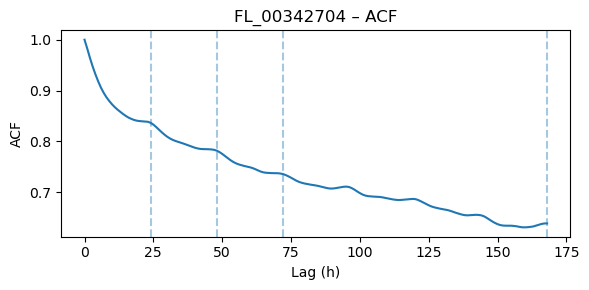

In [17]:
acf_plot(Z['FL_00342704.PLAN.MengeGA'], title="FL_00342704 – ACF")

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import normalize

# Cosine-ähnlich: erst L2-normalisieren, dann KMeans (Euclid ≈ Cosine)
Xn = normalize(X)

best = {'k': None, 'sil': -1, 'db': np.inf, 'labels': None, 'model': None}
for k in range(2, min(12, len(keys))):  # 2..11
    km = KMeans(n_clusters=k, n_init=20, random_state=0)
    lab = km.fit_predict(Xn)
    sil = silhouette_score(Xn, lab)
    db  = davies_bouldin_score(Xn, lab)
    # simple score: maximize silhouette, break ties with low DB
    if sil > best['sil'] or (np.isclose(sil, best['sil']) and db < best['db']):
        best = {'k': k, 'sil': sil, 'db': db, 'labels': lab, 'model': km}

labels = best['labels']
k = best['k']
clusters = {c: [keys[i] for i in range(len(keys)) if labels[i]==c] for c in range(k)}

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\sit

In [9]:
clusters

{0: ['FL_00024702.PLAN.MengeHH',
  'FL_00024730.PLAN.MengeHH',
  'FL_00352243.PLAN.MengeHH',
  'FL_00352244.PLAN.MengeKW',
  'FL_00024731.PLAN.MengeHH',
  'FL_00024735.PLAN.MengeHH',
  'FL_00024667.PLAN.MengeHH',
  'FL_00352218.PLAN.MengeHH',
  'FL_00025240.PLAN.MengeHH',
  'FL_00025241.PLAN.MengeHH',
  'FL_00020896.PLAN.MengeHH',
  'FL_00342704.PLAN.MengeGA',
  'FL_00352054.PLAN.MengeHH',
  'FL_00352254.PLAN.MengeHH',
  'FL_00352244.PLAN.MengeHH',
  'FL_00342704.PLAN.MengeHH',
  'CV_00003083.PLAN.Menge',
  'CV_00003181.PLAN.Menge',
  'CV_00003192.PLAN.Menge',
  'CV_00003191.PLAN.Menge',
  'CV_00003183.PLAN.Menge',
  'CV_00001876.PLAN.Menge',
  'CV_00003094.PLAN.Menge',
  'CV_00003089.PLAN.Menge',
  'CV_00007270.PLAN.Menge',
  'CV_00007300.PLAN.Menge',
  'KN_00000069.PLAN.Menge',
  'KN_00000067.PLAN.Menge',
  'CV_00007809.PLAN.Menge',
  'FL_00352191.PLAN.MengeHH',
  'FL_00352189.PLAN.MengeHH',
  'KN_00001886.PLAN.Menge',
  'KN_00001602.PLAN.Menge',
  'FL_00352430.PLAN.MengeHH',
  'FL_0

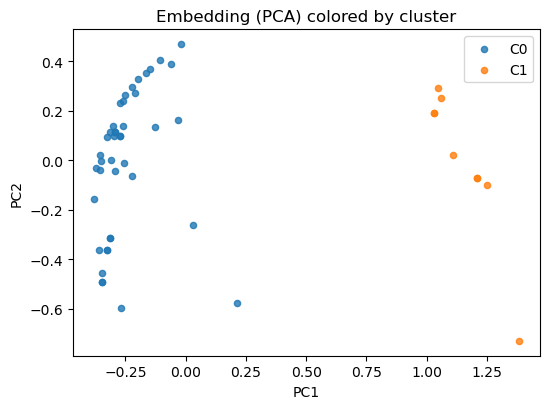

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def scatter_2d(Xn, labels, title="Embedding (PCA) colored by cluster"):
    pca = PCA(n_components=2, random_state=0).fit(Xn)
    XY = pca.transform(Xn)
    plt.figure(figsize=(5.6,4.2))
    for c in np.unique(labels):
        sel = labels==c
        plt.scatter(XY[sel,0], XY[sel,1], s=20, label=f"C{c}", alpha=0.8)
    plt.legend(); plt.title(title); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.tight_layout()

scatter_2d(Xn, labels)

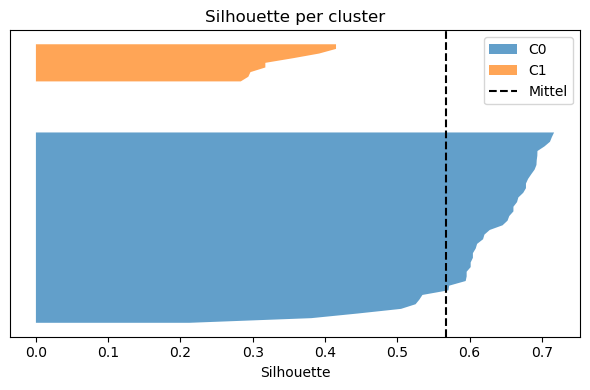

In [19]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples

def silhouette_plot(Xn, labels, title="Silhouette per cluster"):
    sil = silhouette_samples(Xn, labels)
    y_low = 10
    plt.figure(figsize=(6,4))
    for c in np.unique(labels):
        c_sil = np.sort(sil[labels==c])
        y_high = y_low + len(c_sil)
        plt.fill_betweenx(np.arange(y_low, y_high), 0, c_sil, alpha=0.7, label=f"C{c}")
        y_low = y_high + 10
    plt.axvline(np.mean(sil), color='k', ls='--', label='Mittel')
    plt.xlabel("Silhouette"); plt.yticks([]); plt.title(title); plt.legend(); plt.tight_layout()

silhouette_plot(Xn, labels)

In [20]:
def k_selection_plot(ks, silhouettes, db_scores):
    fig, ax1 = plt.subplots(figsize=(6,3))
    ax1.plot(ks, silhouettes, marker='o'); ax1.set_xlabel('k'); ax1.set_ylabel('Silhouette')
    ax2 = ax1.twinx()
    ax2.plot(ks, db_scores, marker='s', ls='--'); ax2.set_ylabel('Davies–Bouldin')
    plt.title("k-Selection"); plt.tight_layout()

k_selection_plot(list_of_k, list_of_sil, list_of_db)

NameError: name 'list_of_k' is not defined

In [10]:
from sklearn.metrics.pairwise import cosine_distances

def cluster_medoid(idxs):
    D = cosine_distances(Xn[idxs], Xn[idxs])
    midx = idxs[D.mean(axis=1).argmin()]
    return midx

cluster_medoids = {}
for c, members in clusters.items():
    idxs = [keys.index(m) for m in members]
    mid = cluster_medoid(idxs)
    cluster_medoids[c] = keys[mid]

In [11]:
cluster_medoids

{0: 'FL_00352243.PLAN.MengeHH', 1: 'FL_00352244.PLAN.MengeGA'}

C:\Users\johan\AppData\Local\Temp\ipykernel_37756\3506409828.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels_order, showfliers=True)


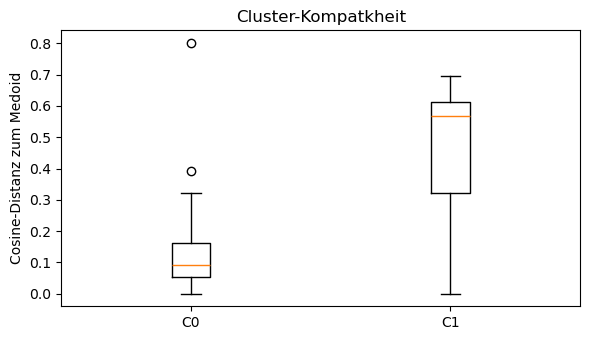

In [21]:
from sklearn.metrics.pairwise import cosine_distances

def dist_to_medoid_plots(Xn, clusters, cluster_medoids):
    fig, ax = plt.subplots(figsize=(6,3.5))
    data = []
    labels_order = []
    for c, members in clusters.items():
        idxs = [keys.index(m) for m in members]
        mid_key = cluster_medoids[c]
        midx = keys.index(mid_key)
        d = cosine_distances(Xn[idxs], Xn[midx:midx+1]).ravel()
        data.append(d); labels_order.append(f"C{c}")
    ax.boxplot(data, labels=labels_order, showfliers=True)
    ax.set_ylabel("Cosine-Distanz zum Medoid"); ax.set_title("Cluster-Kompatkheit"); plt.tight_layout()

dist_to_medoid_plots(Xn, clusters, cluster_medoids)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset

# --- Daten vorbereiten ---
# Deine series_dfs ist ein dict mit DataFrames
# Wir extrahieren die Spalte 'consumption' als Zeitreihen
time_series_list = []
names = []

for key, df in series_dfs.items():
    ts = df['consumption'].values
    ts = (ts - ts.mean()) / ts.std()  # z-Score Normalisierung
    time_series_list.append(ts)
    names.append(key)

# In tslearn-Format bringen
X = to_time_series_dataset(time_series_list)

# --- Clustering mit DTW ---
n_clusters = 4  # Clusteranzahl, nach Bedarf anpassen
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
labels = model.fit_predict(X)

# --- Ergebnisse plotten ---
for cluster_id in range(n_clusters):
    plt.figure(figsize=(10,4))
    plt.title(f"Cluster {cluster_id}")
    for i, ts in enumerate(X):
        if labels[i] == cluster_id:
            plt.plot(ts.ravel(), alpha=0.3)  # alle Serien im Cluster
    plt.plot(model.cluster_centers_[cluster_id].ravel(), color="red", linewidth=2)  # Cluster-Zentrum
    plt.show()

In [ ]:
x